In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Config ----
ENDPOINT = "PPARG agonist"           # target endpoint to highlight
PVAL_PREFIX = "adj_pval_"
RAW_PVAL_PREFIX = "raw_pval_"
ACT_PREFIX = "%_active_"

# ---- I/O paths (edit as needed) ----
CLUSTERING_CSV = "clustering_result.csv"          # contains cluster-level stats, t-SNE, p-values, etc.
STANDARDIZED_XLSX = "data/StandardizedTox21Results.xlsx"
DESCRIPTOR_XLSX = "docking_result.xlsx"

# ---- Load data ----
clustering_df = pd.read_csv(CLUSTERING_CSV, index_col=0)

# Optional / for downstream use
tox21_hts = pd.read_excel(STANDARDIZED_XLSX)      # full standardized HTS table
descriptor_df = pd.read_excel(DESCRIPTOR_XLSX, index_col=0)

# ---- Sanity checks ----
required_cols = {"cluster", f"{PVAL_PREFIX}{ENDPOINT}"}
missing = [c for c in required_cols if c not in clustering_df.columns]
if missing:
    raise KeyError(f"Missing required columns in clustering_df: {missing}")

# (Optional) extract t-SNE coords if present
tsne_cols = [c for c in ["TSNE1", "TSNE2"] if c in clustering_df.columns]
if len(tsne_cols) != 2:
    print("Note: t-SNE columns not found (TSNE1, TSNE2). Skipping t-SNE-based plots.")
else:
    tSNE_coord = clustering_df[tsne_cols].copy()

# Basic style
sns.set_context("talk")
sns.set_style("whitegrid")

/tmp/ipykernel_1039191/3891360656.py:70: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


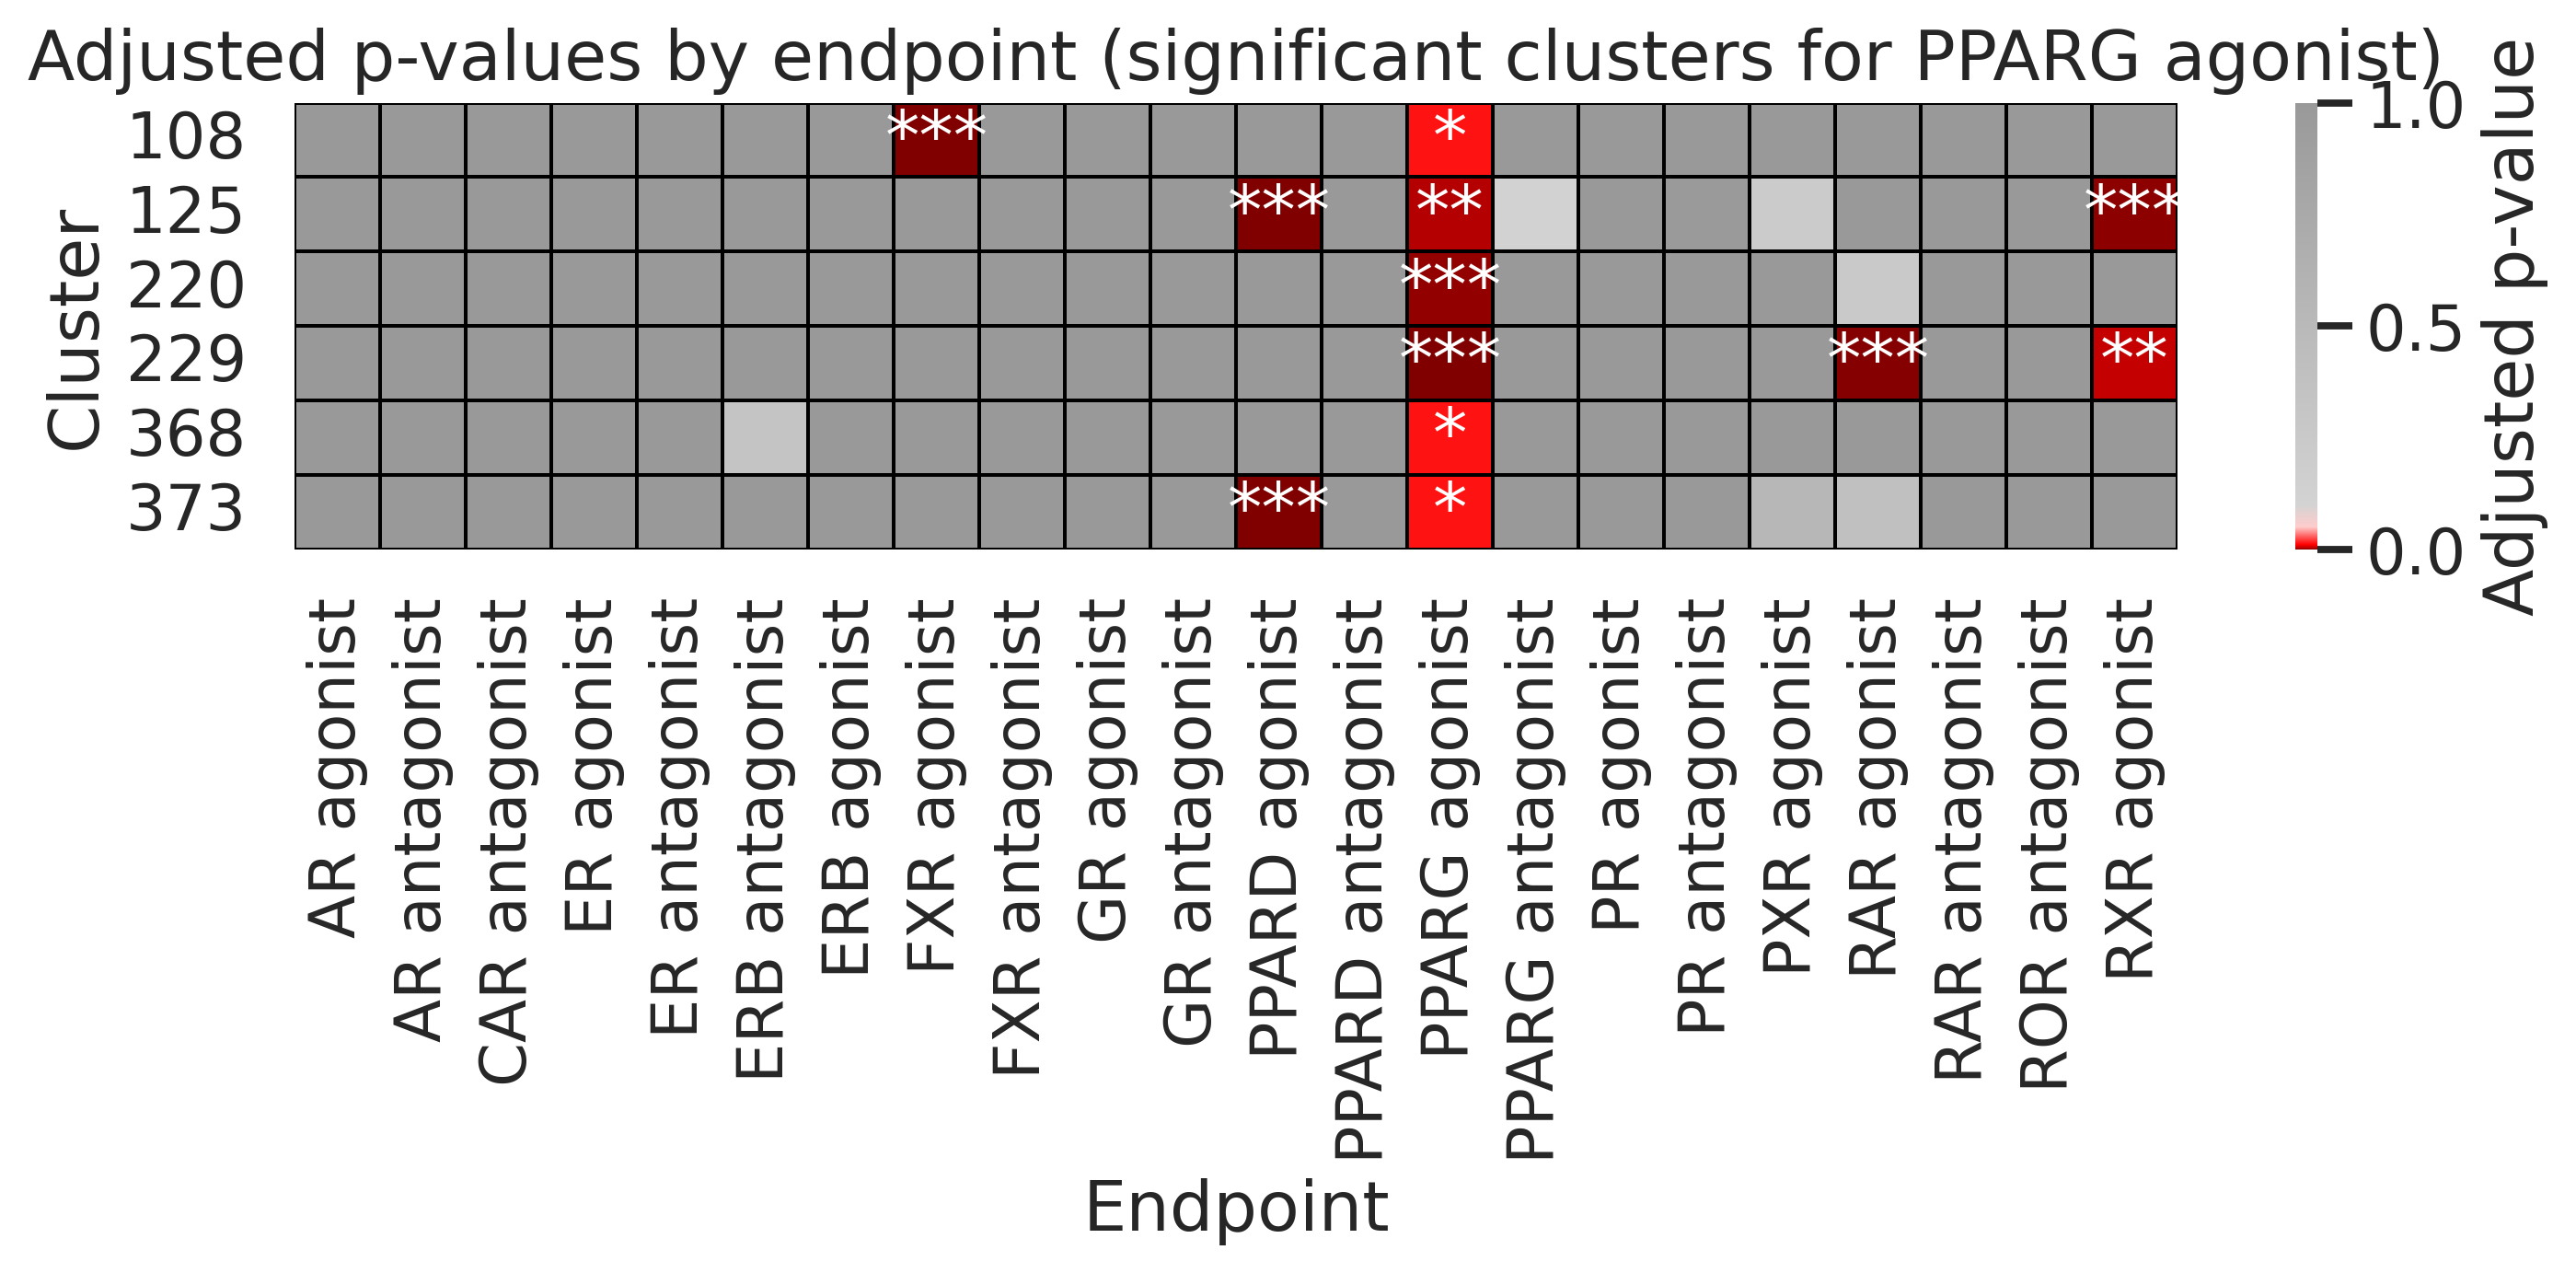

In [2]:
from matplotlib.colors import LinearSegmentedColormap

# ---- Select significant clusters for the chosen endpoint ----
sig_mask = clustering_df[f"{PVAL_PREFIX}{ENDPOINT}"] < 0.05
sig_df = clustering_df.loc[sig_mask].copy()
clusters = sorted(sig_df["cluster"].unique())

if len(clusters) == 0:
    raise ValueError(f"No clusters pass FDR < 0.05 for endpoint: {ENDPOINT}")

# ---- Build wide p-value matrix for ALL endpoints available in this table ----
# Any column starting with 'adj_pval_' is treated as an endpoint
all_pval_cols = [c for c in clustering_df.columns if c.startswith(PVAL_PREFIX)]
if not all_pval_cols:
    raise KeyError("No adjusted p-value columns (adj_pval_*) found.")

# Subset to significant clusters, pivot to matrix
pvals_df = (
    clustering_df[["cluster"] + all_pval_cols]
    .drop_duplicates()
    .set_index("cluster")
    .loc[clusters]     # keep order of significant clusters
    .copy()
)

# Clean column labels to show endpoint names without the prefix
pvals_df.columns = [c.replace(PVAL_PREFIX, "") for c in pvals_df.columns]

# ---- Star annotation ----
def star_annot(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    return ""

annot_df = pvals_df.applymap(star_annot)

# ---- Colormap (p→0 = dark red; p≈0.05 = light red; high p = gray) ----
cmap_heatmap = LinearSegmentedColormap.from_list(
    "pval_red_grad",
    [
        (0.00, "#800000"),  # darkest red at p→0
        (0.001, "#AA0000"),
        (0.01, "#FF0000"),
        (0.05, "#FFCCCC"),  # light red near 0.05
        (0.10, "#D3D3D3"),  # light gray
        (1.00, "#999999"),  # gray at high p
    ],
    N=16384
)

plt.figure(figsize=(max(8, 0.5*len(pvals_df.columns)), 0.35*len(pvals_df)), dpi=300)
sns.heatmap(
    pvals_df,
    annot=annot_df,
    fmt="",
    cmap=cmap_heatmap,
    vmin=0, vmax=1,
    cbar_kws={"label": "Adjusted p-value"},
    linewidths=0.5,
    linecolor="black"
)
plt.title(f"Adjusted p-values by endpoint (significant clusters for {ENDPOINT})")
plt.ylabel("Cluster")
plt.xlabel("Endpoint")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [3]:
cols_to_show = [
    "cluster",
    f"{ACT_PREFIX}{ENDPOINT}",
    f"{RAW_PVAL_PREFIX}{ENDPOINT}",
    f"{PVAL_PREFIX}{ENDPOINT}",
]
missing_cols = [c for c in cols_to_show if c not in clustering_df.columns]
if missing_cols:
    raise KeyError(f"These columns are missing for the endpoint table: {missing_cols}")

sig_table = (
    clustering_df.loc[clustering_df[f"{PVAL_PREFIX}{ENDPOINT}"] < 0.05, cols_to_show]
    .drop_duplicates()
    .sort_values(by="cluster")
    .reset_index(drop=True)
)
sig_table

,cluster,%_active_PPARG agonist,raw_pval_PPARG agonist,adj_pval_PPARG agonist
0,108,40.000,1.274269e-04,1.352849e-02
1,125,15.000,1.000085e-05,2.123513e-03
2,220,20.000,1.436140e-06,4.574105e-04
3,229,28.125,1.984022e-17,1.263822e-14
4,368,40.000,1.274269e-04,1.352849e-02
5,373,40.000,1.274269e-04,1.352849e-02


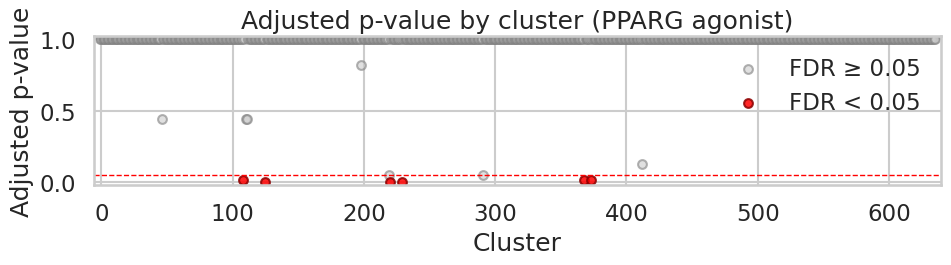

In [4]:
plot_df = (
    clustering_df[["cluster", f"{PVAL_PREFIX}{ENDPOINT}"]]
    .drop_duplicates()
    .set_index("cluster")
    .sort_index()
)
x = plot_df.index.values
y = plot_df[f"{PVAL_PREFIX}{ENDPOINT}"].values

sig_mask = y < 0.05
non_sig_mask = ~sig_mask

plt.figure(figsize=(10, 3))
plt.scatter(x[non_sig_mask], y[non_sig_mask], c="#CCCCCC", edgecolors="gray", alpha=0.6, s=40, label="FDR ≥ 0.05")
plt.scatter(x[sig_mask], y[sig_mask], c="red", edgecolors="darkred", alpha=0.85, s=40, label="FDR < 0.05")
plt.axhline(0.05, linestyle="--", color="red", linewidth=1)

plt.title(f"Adjusted p-value by cluster ({ENDPOINT})")
plt.xlabel("Cluster")
plt.ylabel("Adjusted p-value")
plt.xlim(x.min() - 5, x.max() + 5)
plt.ylim(-0.02, 1.02)
plt.legend(frameon=False, loc="upper right")
plt.tight_layout()
plt.show()

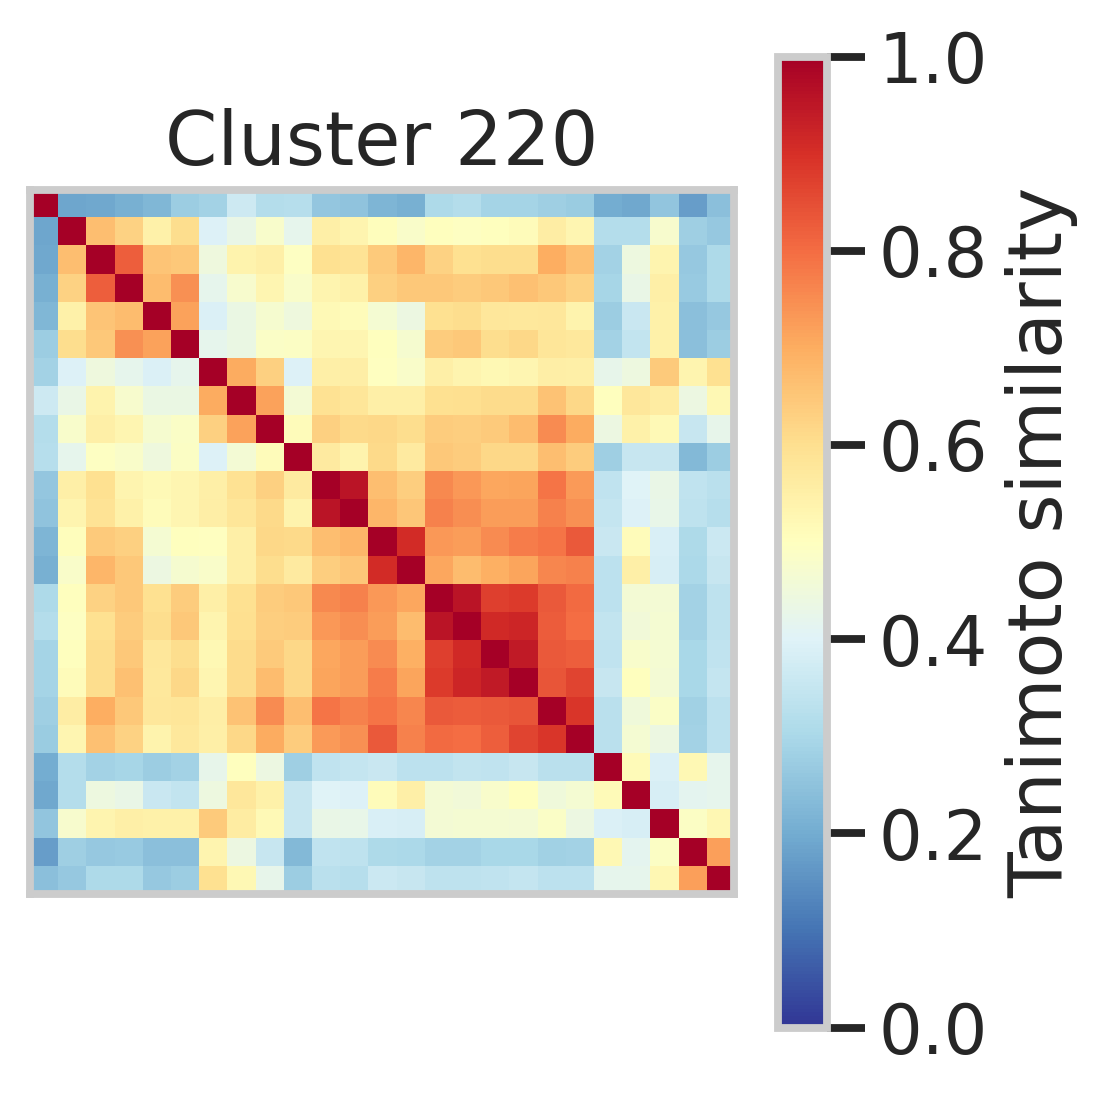

Cluster 220, ordered DataFrame:


,TSNE1,TSNE2,cluster,SAMPLE_NAME,std_SMILES,AR agonist,AR antagonist,CAR antagonist,ER agonist,ER antagonist,...,adj_pval_RAR agonist,%_active_RAR antagonist,raw_pval_RAR antagonist,adj_pval_RAR antagonist,%_active_ROR antagonist,raw_pval_ROR antagonist,adj_pval_ROR antagonist,%_active_RXR agonist,raw_pval_RXR agonist,adj_pval_RXR agonist
lig1549,5.710214,-12.468987,220,Neboglamine,CC1(C)CCC(NC(=O)C(N)CCC(=O)O)CC1,Inactive,Inactive,Inconclusive,Inactive,Inactive,...,0.254438,0.0,0.439064,1.0,0.0,0.571945,1.0,4.0,0.894128,1.0
lig4238,2.491989,-10.907637,220,Sulisobenzone,COc1cc(O)c(C(=O)c2ccccc2)cc1S(=O)(=O)O,Inactive,Inactive,Inactive,Inactive,Inactive,...,0.254438,0.0,0.439064,1.0,0.0,0.571945,1.0,4.0,0.894128,1.0
lig4329,4.544750,-10.537793,220,Anisindione,COc1ccc(C2C(=O)c3ccccc3C2=O)cc1,Inactive,Inactive,Inconclusive,Inactive,Inactive,...,0.254438,0.0,0.439064,1.0,0.0,0.571945,1.0,4.0,0.894128,1.0
lig4417,6.825238,-12.069572,220,Nabumetone,COc1ccc2cc(CCC(C)=O)ccc2c1,Inactive,Inactive,Inconclusive,Inactive,Inactive,...,0.254438,0.0,0.439064,1.0,0.0,0.571945,1.0,4.0,0.894128,1.0
lig1010,5.080137,-12.223831,220,Ciprofibrate,CC(C)(Oc1ccc(C2CC2(Cl)Cl)cc1)C(=O)O,Inactive,Inactive,Inactive,Inactive,Inactive,...,0.254438,0.0,0.439064,1.0,0.0,0.571945,1.0,4.0,0.894128,1.0
lig4947,5.351756,-11.442339,220,Gemfibrozil,Cc1ccc(C)c(OCCCC(C)(C)C(=O)O)c1,Inactive,Inactive,Inactive,Inactive,Inactive,...,0.254438,0.0,0.439064,1.0,0.0,0.571945,1.0,4.0,0.894128,1.0
lig4930,4.751936,-11.197176,220,Tolmetin sodium dihydrate,Cc1ccc(C(=O)c2ccc(CC(=O)O)n2C)cc1,Inconclusive,Inconclusive,Inactive,Inactive,Inconclusive,...,0.254438,0.0,0.439064,1.0,0.0,0.571945,1.0,4.0,0.894128,1.0
lig0829,3.390325,-14.755340,220,Indoprofen,CC(C(=O)O)c1ccc(N2Cc3ccccc3C2=O)cc1,Inconclusive,Inactive,Inconclusive,Inconclusive,Inactive,...,0.254438,0.0,0.439064,1.0,0.0,0.571945,1.0,4.0,0.894128,1.0
lig5884,2.913605,-11.917903,220,Amfenac sodium,Nc1c(CC(=O)O)cccc1C(=O)c1ccccc1,Inconclusive,Inactive,Inconclusive,Inactive,Inactive,...,0.254438,0.0,0.439064,1.0,0.0,0.571945,1.0,4.0,0.894128,1.0
lig0823,3.660581,-13.561314,220,Pelubiprofen,CC(C(=O)O)=c1ccc(=CC2CCCCC2=O)cc1,Inactive,Inactive,Inconclusive,Inactive,Inactive,...,0.254438,0.0,0.439064,1.0,0.0,0.571945,1.0,4.0,0.894128,1.0


In [5]:
from utils.cheminfo_utils import generate_PubchemFP
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

def draw_cluster_heatmap_df(df: pd.DataFrame, smiles_col: str = "std_SMILES", title: str | None = None):
    """
    Build a PubChem-fingerprint Tanimoto similarity matrix for the SMILES in df[smiles_col],
    perform hierarchical clustering, and plot an ordered heatmap.
    Returns the DataFrame reordered according to the clustering.
    Rows with invalid/failed fingerprints are dropped.
    """
    # Compute fingerprints and collect valid indices
    fps_data = []
    for idx, smi in df[smiles_col].items():
        fp = generate_PubchemFP(smi)
        if fp is not None:
            fps_data.append((idx, fp))

    if len(fps_data) < 2:
        print("Not enough valid fingerprints to plot heatmap.")
        valid_idx = [idx for idx, _ in fps_data]
        return df.loc[valid_idx].copy()

    orig_idxs, fps = zip(*fps_data)
    fps = list(fps)
    n = len(fps)

    # Build full Tanimoto similarity matrix
    sim = np.zeros((n, n), dtype=float)
    # Precompute bit counts to avoid repeated sums
    bit_counts = np.array([fp.sum() for fp in fps], dtype=float)

    for i in range(n):
        ai = fps[i]
        ai_sum = bit_counts[i]
        sim[i, i] = 1.0
        for j in range(i + 1, n):
            aj = fps[j]
            common = np.bitwise_and(ai, aj).sum()
            denom = ai_sum + bit_counts[j] - common
            sim_val = (common / denom) if denom > 0 else 0.0
            sim[i, j] = sim[j, i] = sim_val

    # Hierarchical clustering on distance = 1 - similarity
    dist = 1.0 - sim
    condensed = squareform(dist, checks=False)
    Z = linkage(condensed, method="average")
    leaf_order = dendrogram(Z, no_plot=True)["leaves"]

    # Reorder matrix and original indices
    sim_ordered = sim[np.ix_(leaf_order, leaf_order)]
    ordered_idxs = [orig_idxs[i] for i in leaf_order]

    # Plot heatmap (axis ticks hidden)
    plt.figure(figsize=(4, 4), dpi=300)
    plt.imshow(sim_ordered, interpolation="nearest", cmap="RdYlBu_r", vmin=0, vmax=1)
    plt.colorbar(label="Tanimoto similarity")
    if title:
        plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

    # Return df in clustered order (only valid rows)
    return df.loc[ordered_idxs].copy()

# ---- Cluster 220 ----
target_cluster = 220
sub = clustering_df.loc[clustering_df["cluster"] == target_cluster].copy()

# Require a SMILES column (standardized) to exist in sub; merge if needed
# If clustering_df does not carry SMILES, join from tox21_hts using a key (e.g., SAMPLE_NAME) before calling.
if "std_SMILES" not in sub.columns and "std_SMILES" in tox21_hts.columns:
    # Example join path (adjust as needed): assume SAMPLE_NAME is present on both
    key = "SAMPLE_NAME"
    if key in sub.columns and key in tox21_hts.columns:
        sub = sub.merge(tox21_hts[[key, "std_SMILES"]].drop_duplicates(), on=key, how="left")

if "std_SMILES" not in sub.columns:
    raise KeyError("std_SMILES column not available for the selected cluster. Join it from tox21_hts before plotting.")

ordered_sub = draw_cluster_heatmap_df(sub.dropna(subset=["std_SMILES"]), smiles_col="std_SMILES",
                                      title=f"Cluster {target_cluster}")
print(f"Cluster {target_cluster}, ordered DataFrame:")
display(ordered_sub)